
<img src='http://linked.earth/FROGS/images/Pyrateslogo.jpg' width="400">

# Chapter 1: Introduction to Timeseries

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), University of Southern California

## Background

Recall that a timeseries $X(t)$ is an ordered data sequence, either continuous or discrete. On a computer, everything is discretized, so regardless of the original process, what we have is a discrete sequence $X_1, \cdots, X_n$, with each $X_i$ corresponding to times $t_i$ in $t_1, \cdots, t_n$.

In timeseries analysis, it is common to consider $X(t)$ as the sum of one or more oscillatory, stationary components (or ``signals''); a **trend** $q(t)$, and **noise** $\varepsilon_t$.  The oscillatory components are often the reason we're doing the analysis in the first place -- it will tell us how big they are and what their frequency is. 

Whether or not those oscillatory components are present, a **trend** is often present as well. 
In today's world the word "trend" is so overused that it has lost all meaning. Here, it will refer to a **slowly-evolving, non-stationary component that dominates the behavior of the timeseries**. For instance: a linear increase or decrease; a sinusoidal component so slow that its period is not resolved by the dataset; a nonlinear trend like the exponential increase of the Keeling curve (see below). 

As for **noise**, it clearly involves a subjective definition. Under this name we usually subsume any variable component in which we are not interested. Some of this noise may be composed of actual measurement errors (what you would think of as noise, strictly speaking), but some of it could be what another analyst would call "signal"". If you study climate, daily fluctuations are noise; if you study weather, they are your signal.  One commonly says that *one analyst's signal is another analyst's noise*.  This noise is often modeled as a Normal random process with zero mean, $\varepsilon \sim \mathcal{N}(0,\sigma^2)$ (aka "Gaussian white noise") .

To see these concepts in action, let us consider the [iconic Keeling curve](https://www.acs.org/education/whatischemistry/landmarks/keeling-curve.html) from the Mauna Loa Observatory $CO_2$ measurements. The data are available [here](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html). In addition to the usual scientific Python stack, we will be using [pandas](https://pandas.pydata.org/) and [statsmodels](http://www.statsmodels.org/stable/index.html). Let us load these packages: 

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Data Wrangling
We use [pandas](https://pandas.pydata.org/) to load the data, which are in csv. Pandas can load directly over the network, so all we need to give it is a URL of the file (here, https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv). 
Let's try it:

In [4]:
url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'
df = pd.read_csv(url)
df.head() # this will show the first few rows of the dataset

ParserError: Error tokenizing data. C error: Expected 1 fields in line 35, saw 4


#### Question

Q: What went wrong? To debug, you'll have to download the file and look at it (do it). What do you see that a machine might have problems with? 

Hint: https://www.askpython.com/python-modules/pandas/pandas-read-csv-with-headers

A: This csv file has a long header. pandas needs to be told how many lines to skip.

Another issue is that the name of the columns for the dataset span two rows, which `pandas` won't be able to deal with on its own. So we need to give it 2 pieces of information:
1. How long the header is
2. What the column names are (which we can lift from the header manually)

We do this by passing two extra arguments to `read_csv()`:

In [3]:
cols = ['Yr','Mn','XLDate','Date','CO2','seasonally adjusted','fit','seasonally adjusted fit','CO2 filled',	'seasonally adjusted filled','Sta']
df = pd.read_csv(url,header=64, names=cols) # read in the data
df.head() # display the top

,Yr,Mn,XLDate,Date,CO2,seasonally adjusted,fit,seasonally adjusted fit,CO2 filled,seasonally adjusted filled,Sta
0,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
1,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44,MLO
2,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16,MLO
3,1958,5,21320,1958.3699,317.51,314.69,317.89,315.07,317.51,314.69,MLO
4,1958,6,21351,1958.4548,-99.99,-99.99,317.27,315.15,317.27,315.15,MLO


By default, `pandas` indexed the rows by their number (starting at 0 as it's Python). Let's extract the actual dates, convert them to a usable format, and re-index the dataframe:

In [4]:
date = pd.to_datetime(df['XLDate'], unit='D', origin='1899-12-30') # convert from Excel's weird standard to something human-readable
date.name = None
df.index=date
df.head()

,Yr,Mn,XLDate,Date,CO2,seasonally adjusted,fit,seasonally adjusted fit,CO2 filled,seasonally adjusted filled,Sta
1958-02-15,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
1958-03-15,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44,MLO
1958-04-15,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16,MLO
1958-05-15,1958,5,21320,1958.3699,317.51,314.69,317.89,315.07,317.51,314.69,MLO
1958-06-15,1958,6,21351,1958.4548,-99.99,-99.99,317.27,315.15,317.27,315.15,MLO


Next, let's extract the column that we want to play with and make a new data frame out of it: 

In [5]:
co2 = df[['Date','CO2 filled']]
co2.rename(columns={'Date': 'Year', 'CO2 filled': 'CO2'},inplace=True) # rename columns for clarity
co2.head()

,Year,CO2
1958-02-15,1958.1260,-99.99
1958-03-15,1958.2027,315.71
1958-04-15,1958.2877,317.45
1958-05-15,1958.3699,317.51
1958-06-15,1958.4548,317.27


One last thing: the first and last value are missing, and they are encoded as -99, which is rather annoying (but unfortunately common; [NaN](https://en.wikipedia.org/wiki/NaN) would be a much less disruptive choice), so let's restrict our analysis to a safe, 66y interval:

In [6]:
co2 = co2.loc['1958-03-15':'2024-02-15']

Now we can sit back and admire our work. 


#### Question
Q: plot CO2 as a function of time

Hint: use pandas's [plot function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html). 

A:

<Axes: title={'center': 'Mauna Loa Dataset (latest)'}, ylabel='CO2 [ppm]'>

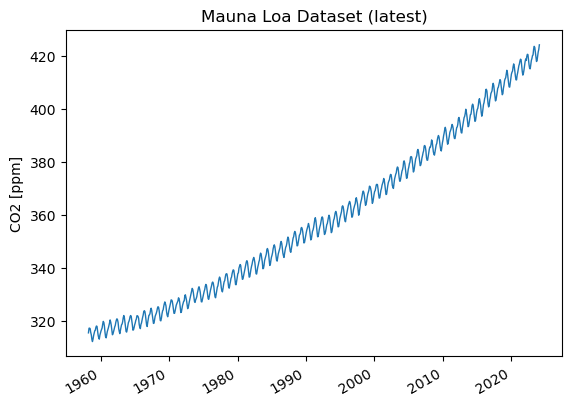

In [7]:
co2['CO2'].plot(linewidth=1,ylabel='CO2 [ppm]',title="Mauna Loa Dataset (latest)")

Now we can sit back and admire our work. 


#### Question
Q: plot CO2 as a function of time

Hint: use pandas's [plot function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html). 

A:

## 2. Trend Extraction

## 2.1 Linear trend model


The most obvious thing to do is to see if a linear trend might fit the data.  In this case it's likely to be a poor approximation, as the previous plot should make obvious. However, it will be an instructive benchmarks for the finer modeling choices we'll subsequently make.

Let's first load the statsmodels API (=Application Programming Interface) to use its packages. What is happening under the hood is a simple linear regression, which you don't need to know much about at this stage. Specifically, we will use the [OLS method](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html). which relates a predictand $y$ to a matrix of predictors $X$, called the *design matrix*. 

In [34]:
t = co2['Year']
y = co2['CO2']
X = np.vander(t, 2) # set up design matrix with 1, t as predictors

import statsmodels.api as sm
lin_mdl = sm.OLS(y, X).fit() # fit the OLS model to the observations

Let's pause and contemplate this, for a moment. 

First, we set up the design matrix X as a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix); there is nothing particularly profound here; it is just a nice way to set this up in one function call.
Second, we fit the model and that just involved importing a module and calling a *fit()* function. 
You have NO IDEA how lucky you are to have grown up in an age where fitting statistical models is that easy. Just like democracy, this is someting that has cost the blood, sweat and tears of countless generations before you, so you had better be grateful!

But there's more. stasmodels is an example of **object-oriented** programming. It means that every model object created by this code enjoys a wide array of properties and utilities. 

The first is a stunningly gorgeous summary of the model fit:

In [10]:
print(lin_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 3.162e+04
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        15:37:39   Log-Likelihood:                -2382.0
No. Observations:                 792   AIC:                             4768.
Df Residuals:                     790   BIC:                             4777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6262      0.009    177.832      0.0

For more information about what each term means, see [this post](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)

What information can you glean from this summary? What features would you check for in a visual inspection?

[ANSWER HERE]

Let us look at the plot, shall we? How well does the time variable predict $CO_2$?

Next, we can use the *predict()* method to predict CO2 given the design matrix (1, $t$)

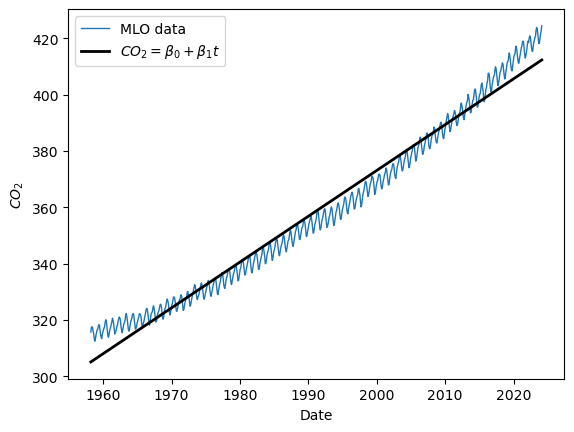

In [11]:
yhat = lin_mdl.predict(X) 
plt.plot(t, y, label="MLO data",linewidth=1)
plt.plot(t, yhat, label=r"$CO_2 = \beta_0 + \beta_1 t$", color='black', linewidth='2')
plt.ylabel(r"$CO_2$")
plt.xlabel("Date")
plt.legend()

We see that the line captures the first order behavior of the series, but that leaves a lot to be desired. To zoom in, we can look at the **residuals** (original values - fitted values) as a function of fitted values:

Text(0, 0.5, 'Residuals')

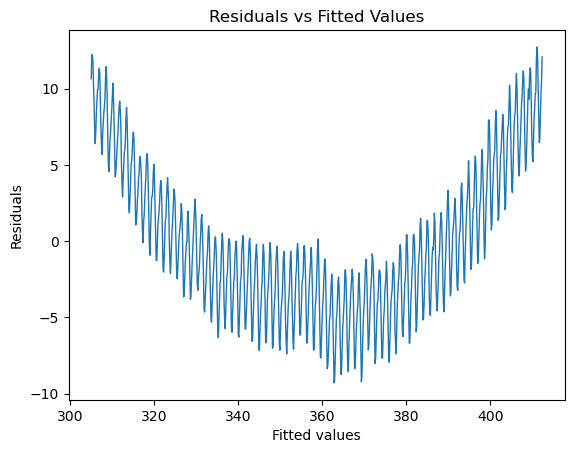

In [12]:
fig, ax = plt.subplots()
ax.plot(lin_mdl.fittedvalues,lin_mdl.resid,linewidth=1)
ax.set_title('Residuals vs Fitted Values')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

To be quantitative, we can look at the [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root_mean_square_deviation) of these residuals:

In [13]:
print('RMSE = ' + '{:4.4f}'.format(np.sqrt(lin_mdl.mse_resid)) + ' ppm')

RMSE = 4.9033 ppm


This means that this linear trend is, on average, about 5ppm away from the measurements. Can we do better?

### 2.2. Quadratic fit

The second thing one might do is to add a quadratic term. Again, the Vandermonde matrix makes this very easy:

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 7.812e+04
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        15:38:01   Log-Likelihood:                -1756.7
No. Observations:                 792   AIC:                             3519.
Df Residuals:                     789   BIC:                             3533.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0134      0.000     55.121      0.0

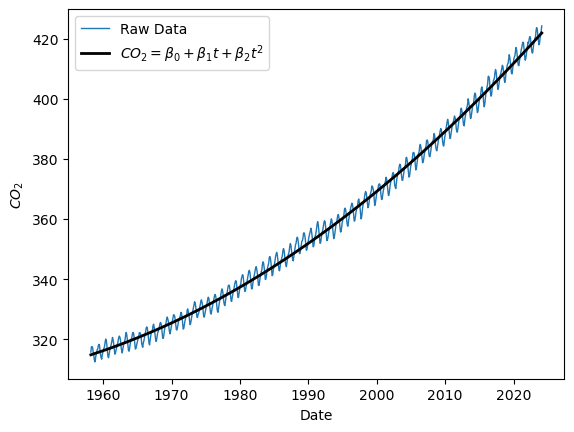

In [14]:
X = np.vander(t, 3) # set up design matrix with 1, t, and t^2 as predictors
quad_mdl = sm.OLS(y, X).fit()
print(quad_mdl.summary())
# plot predicted values
yhat = quad_mdl.predict(X) 
plt.plot(t, y, label="Raw Data",linewidth=1)
plt.plot(t, yhat, label=r"$CO_2 = \beta_0 + \beta_1 t + \beta_2 t^2$", color='black', linewidth='2')
plt.ylabel(r"$CO_2$")
plt.xlabel("Date")
plt.legend()

RMSE = 2.2277 ppm


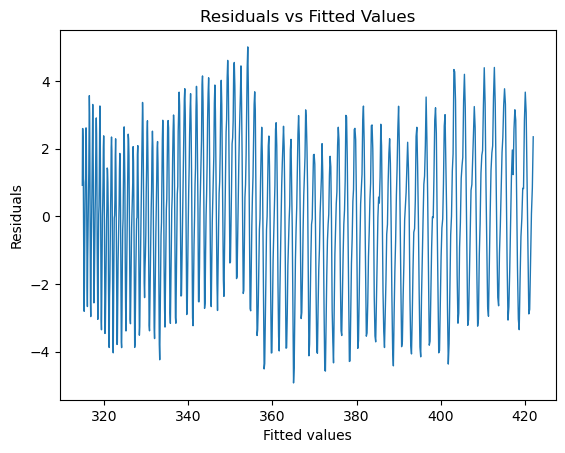

In [15]:
fig, ax = plt.subplots()
ax.plot(quad_mdl.fittedvalues,quad_mdl.resid,linewidth=1)
ax.set_title('Residuals vs Fitted Values')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
print('RMSE = ' + '{:4.4f}'.format(np.sqrt(quad_mdl.mse_resid)) + ' ppm')



__Question 3__ 
Does this improve the fit?  By how much have we shrunk the RMSE of residuals?

Comment in detail on how the addition of a quadratic term has changed plots a, b c and d. What issues have been solved? What issues remain?

[ANSWERS HERE]

## 3. Adding Periodic components

It should be obvious from the simple visual inspection of the original series that there is a strong periodic component we are not currently capturing. It turns out to the a simple seasonal cycle: in spring/summer, the growth of terrestrial biomass sequesters CO2 away from the atmosphere, so the atmospheric CO2 concentrations goes down; the reverse happens in the Fall/Winter, where the fallen leaves are degraded and their organic carbon returned to mineral (CO2) form via respiration. 

Let us thus define harmonic waves (sines and cosines) with a period of 1 year and add them to the design matrix.

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.213e+05
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        15:38:15   Log-Likelihood:                -1070.5
No. Observations:                 792   AIC:                             2151.
Df Residuals:                     787   BIC:                             2174.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0134      0.000    130.916      0.0

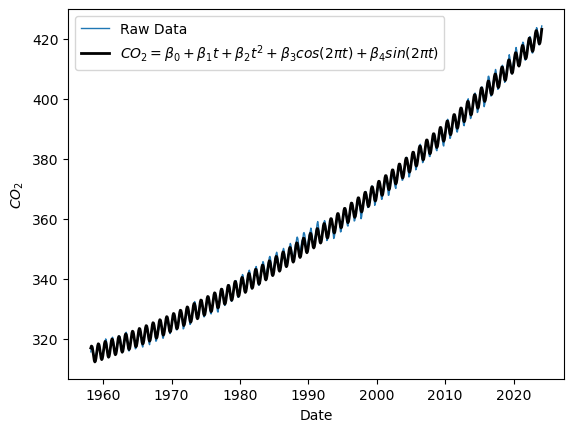

In [16]:
H = np.column_stack((np.cos(2*np.pi*t),np.sin(2*np.pi*t)))
Xh = np.concatenate((np.vander(t, 3),H),axis=1)
seas_mdl = sm.OLS(y, Xh).fit()
print(seas_mdl.summary())
# plot predicted values
yhat = seas_mdl.predict(Xh) 
plt.plot(t, y, label="Raw Data",linewidth=1)
plt.plot(t, yhat, label=r"$CO_2 = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 cos(2\pi t) + \beta_4 sin(2\pi t)  $", color='black', linewidth='2')
plt.ylabel(r"$CO_2$")
plt.xlabel("Date")
plt.legend()

RMSE = 0.9379 ppm


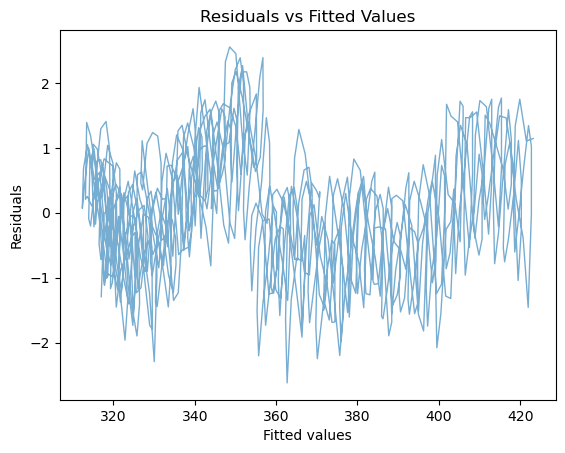

In [20]:
fig, ax = plt.subplots()
ax.plot(seas_mdl.fittedvalues,seas_mdl.resid,linewidth=1, alpha = 0.6)
ax.set_title('Residuals vs Fitted Values')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
print('RMSE = ' + '{:4.4f}'.format(np.sqrt(seas_mdl.mse_resid)) + ' ppm')

__Question 4__ 

This should look better. Does it?  By how much have we shrunk the RMSE of residuals?

In [31]:
print('{:4.4f}'.format(100*(1-np.sqrt(seas_mdl.mse_resid/lin_mdl.mse_resid))))

80.8727


Answer: over 80% improvement!

### Seasonal-Trend decomposition using LOESS (STL)
As it turns out, statsmodels already contains much more sophisticated tools to do this sort of work. Witness [STL decomposition](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#Forecasting-with-STL) in action:

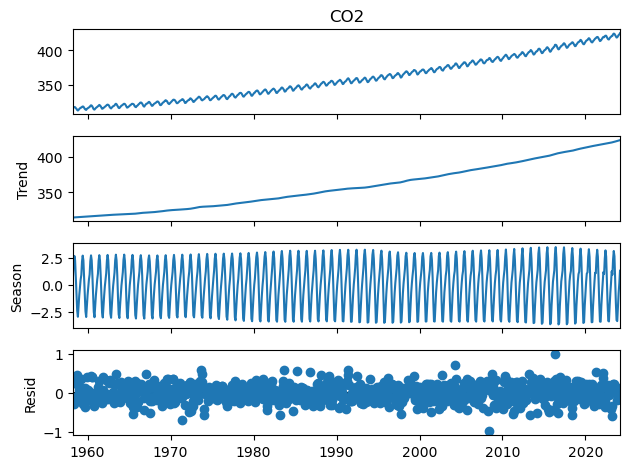

In [21]:
from statsmodels.tsa.seasonal import STL
co2_s = pd.Series(
    co2['CO2'].values, index=pd.date_range("3-15-1958", periods=len(co2), freq="M"), name="CO2"
)
stl = STL(co2_s, seasonal=13)
stl_res = stl.fit()
fig = stl_res.plot()

In [28]:
rmse = np.sqrt(np.square(stl_res._resid.values).mean())
print('RMSE = ' + '{:4.4f}'.format(rmse) + ' ppm')

RMSE = 0.2215 ppm


As we can see, this decomposition got us much, much closer to the observations, with an RMSE of just 0.22 ppm. This is because the seasonal cycle is allowed to fluctuate in amplitude, and the trend is also more general than a quadratic. However, this is more of a black box.

## 4. Forecasting

Let us return to our parametric model of atmospheric $CO_2$ (quadractic trend + seasonal harmonics), which we may use  to forecast future observations. Let's extend our time axis to 2050 and see what $CO_2$ may look like then if we don't curb emissions or fail to remove it from the atmosphere:

In [32]:
tn = t.to_numpy()
dt = np.diff(tn)[0]
tf = np.arange(max(tn)+dt,2050,dt)
tp = np.concatenate((tn,tf))
nf = len(tf) #number of future values to forecast

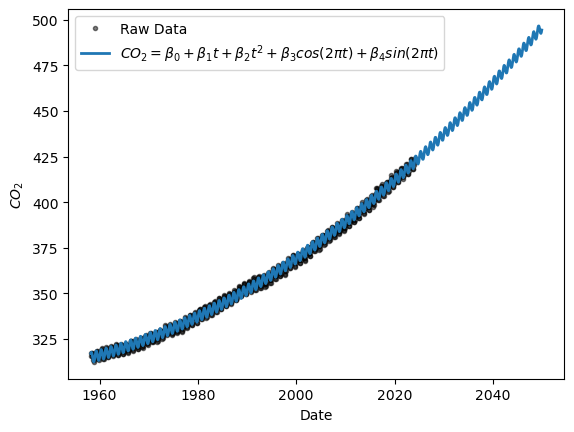

In [33]:
Hp = np.column_stack((np.cos(2*np.pi*tp),np.sin(2*np.pi*tp)))
Xp = np.concatenate((np.vander(tp, 3),Hp),axis=1)

yh = seas_mdl.predict(Xp) 
plt.plot(t, y,'k.',alpha=0.5, label="Raw Data")
plt.plot(tp, yh, label=r"$CO_2 = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 cos(2\pi t) + \beta_4 sin(2\pi t)  $", linewidth='2')
plt.ylabel(r"$CO_2$")
plt.xlabel("Date")
plt.legend()

From this, one can estimate. e.g. the time of first crossing 450 ppm, for instance.

Of course, those predictions are only as good as the data that went into them, and the assumptions that the same processes will continue to operate at the same rate. Note that there are much more sophisticated methods for timeseries forecasting basd on machine learning, e.g. [tsfresh](https://tsfresh.com).   Another option that would likely work here is using seasonal ARIMA models, as done [here](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#Forecasting-with-STL).